In [1]:
import pandas as pd
import midynet
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pyhectiqlab

import os
import shutil

from midynet.utility import display

plt.rc("font", family="serif", size=display.fontsizes["small"])

display.Label.left = display.Label.right = ""

make_run = False

In [2]:
if make_run:
    run = pyhectiqlab.Run(path="netsci-figure-heuristics-with-littlerock", project="dynamica/midynet")


In [3]:
reconinfo = pd.read_pickle("data/heuristics-erdosrenyi-glauber/targeted_reconinfo.pkl")
heuristics = pd.read_pickle("data/heuristics-erdosrenyi-glauber/reconheuristics.pkl")

coupling = reconinfo["heuristics-erdosrenyi-glauber"]["data_model.coupling"].values
methods = np.unique(heuristics["heuristics-erdosrenyi-glauber"]["metrics.method"])


recon = midynet.statistics.Statistics.from_dataframe(reconinfo["heuristics-erdosrenyi-glauber"], "recon")
recon.rescale_(1./32)

heur = midynet.statistics.Statistics.from_dataframe(heuristics["heuristics-erdosrenyi-glauber"], key="auc")
heur = {m: heur[heuristics["heuristics-erdosrenyi-glauber"]["metrics.method"] == m] for m in methods}
for k, v in heur.items():
    v.rescale_(1./32)



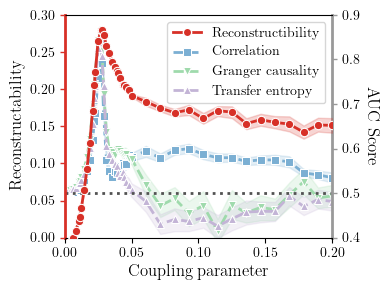

In [4]:
x, aug_recon = recon.interpolate(coupling)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
axx = ax.twinx()
ax.set_zorder(axx.get_zorder()+1)
ax.set_frame_on(False)

colors = [
    display.med_colors["red"], 
    display.light_colors["blue"], 
    display.light_colors["green"], 
    display.light_colors["purple"]
]
recon.lineplot(coupling, color=colors[0], marker="o", ax=ax, linewidth=2, mec="white")
ax.tick_params(axis="y", color=colors[0], width=1)
axx.spines["left"].set_color(colors[0])
axx.spines["left"].set_linewidth(2)

axx.tick_params(axis="y", color=display.light_colors["grey"], width=1)
axx.spines["right"].set_color(display.light_colors["grey"])
axx.spines["right"].set_linewidth(2)

axx.plot([-1], [-1], color=colors[0], marker="o", linewidth=2, mec="white", label="Reconstructibility")

labels = ["Correlation", "Granger causality", "Transfer entropy"]
for i, m in enumerate(methods):
    heur[m].lineplot(
        coupling, 
        ax=axx, 
        interpolate=None, 
        color=colors[i+1], 
        label=labels[i], 
        linestyle="--",
        mec="white",
        linewidth=2,
    )

axx.axhline(0.5, linestyle="dotted", color=display.med_colors["grey"], linewidth=2)
axx.legend(fontsize=display.fontsizes["small"])
ax.set_xlabel("Coupling parameter", fontsize=display.fontsizes["medium"])
ax.set_ylabel(r"Reconstructability", fontsize=display.fontsizes["medium"])
axx.set_ylabel(r"AUC Score", fontsize=display.fontsizes["medium"], rotation=-90, va="bottom")
ax.set_ylim([0, 0.3])
axx.set_ylim([0.4, 0.9])
ax.set_xlim([0, 0.2])
ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2])
# display.Label.counter = 1
# display.Label.plot(ax, loc="top left", fontsize=14, box=False)


fig.tight_layout()
fig.savefig("heuristics.png")
fig.savefig("heuristics.pdf")

if make_run:
    run.add_artifact("heuristics.png")
    run.add_artifact("heuristics.pdf")
    run.add_artifact("data/heuristics-erdosrenyi-glauber/targeted_reconinfo.pkl")
    run.add_artifact("data/heuristics-erdosrenyi-glauber/reconheuristics.pkl")
    
    shutil.copyfile("heuristics.png", "data/heuristics-erdosrenyi-glauber/heuristics.png")
    shutil.copyfile("heuristics.pdf", "data/heuristics-erdosrenyi-glauber/heuristics.pdf")

    run.add_dataset(
        source_path="./data/heuristics-erdosrenyi-glauber/", 
        name="netsci2023-recon-vs-heuristics",
        version="1.1.0",
        push_dir=True,
        resume_upload=True
    )

## Model selection figure

In [8]:
if make_run:
    run_cm = pyhectiqlab.Run(path="netsci-figure-for-model-selection-configuration-glauber", project="dynamica/midynet")
    run_erdos = pyhectiqlab.Run(path="netsci-figure-for-model-selection-erdosrenyi-glauber", project="dynamica/midynet")

## Load data

In [9]:
erdos = pd.read_pickle("data/modelselec-erdosrenyi-glauber/reconinfo.pkl")
target_er = pd.read_pickle("data/modelselec-erdosrenyi-glauber/targeted_reconinfo.pkl")
configuration = pd.read_pickle("data/modelselec-configuration-glauber/reconinfo.pkl")
target_cm = pd.read_pickle("data/modelselec-configuration-glauber/targeted_reconinfo.pkl")

mi = midynet.statistics.Statistics.from_samples(
    target_er["modelselec-erdosrenyi-glauber"]["mutualinfo"], 
    reduction="normal"
)
prior = midynet.statistics.Statistics.from_samples(
    target_er["modelselec-erdosrenyi-glauber"]["prior"], 
    reduction="normal"
)
targ_er = mi / prior

mi = midynet.statistics.Statistics.from_samples(
    target_cm["modelselec-configuration-glauber"]["mutualinfo"], 
    reduction="normal"
)
prior = midynet.statistics.Statistics.from_samples(
    target_cm["modelselec-configuration-glauber"]["prior"], 
    reduction="normal"
)
targ_cm = mi / prior

mi = midynet.statistics.Statistics.from_samples(
    erdos["modelselec-erdosrenyi-glauber"]["mutualinfo"], 
    reduction="normal"
)
prior = midynet.statistics.Statistics.from_samples(
    erdos["modelselec-erdosrenyi-glauber"]["prior"], 
    reduction="normal"
)
recon_er = mi / prior

mi = midynet.statistics.Statistics.from_samples(
    configuration["modelselec-configuration-glauber"]["mutualinfo"], 
    reduction="normal"
)
prior = midynet.statistics.Statistics.from_samples(
    configuration["modelselec-configuration-glauber"]["prior"], 
    reduction="normal"
)
recon_cm = mi / prior

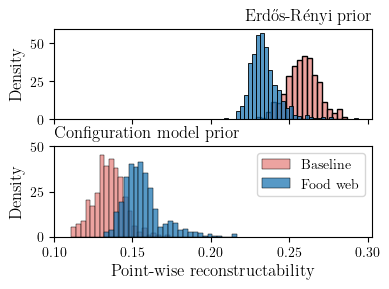

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(4,3), sharex=True)
display.Label.counter = 2

priors = ["erdosrenyi", "configuration"]
title = ["Erd\H{o}s-Rényi prior", "Configuration model prior"]
baseline = [erdos["modelselec-erdosrenyi-glauber"], configuration["modelselec-configuration-glauber"]]
target = [target_er["modelselec-erdosrenyi-glauber"], target_cm["modelselec-configuration-glauber"]]

avgrecon = [recon_er.loc, recon_cm.loc, recon_cm.loc]
avgtarg = [targ_er.loc, targ_cm.loc, targ_cm.loc]
for i in range(2):
    sb.histplot(baseline[i]["recon"], label="Baseline", ax=ax[i], color=display.light_colors["red"], stat="density")
    sb.histplot(target[i]["recon"], label="Food web", ax=ax[i], color=display.med_colors["blue"], stat="density")
#     ax[i].axvline(avgrecon[i], linestyle="-", color=display.dark_colors["grey"], linewidth=2)
#     ax[i].axvline(avgtarg[i], linestyle="-", color=display.dark_colors["grey"], linewidth=2)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Density", fontsize=display.fontsizes["medium"])
    ax[i].set_title(title[i], fontsize=display.fontsizes["medium"], loc="right" if i==0 else "left")
    ax[i].set_xticks(np.linspace(0.1, 0.3, 5))
    ax[i].set_yticks(np.linspace(0.0, 50, 3))
#     display.Label.plot(ax[i], loc="top left", fontsize=14, box=False)
ax[i].set_xlabel("Point-wise reconstructability", fontsize=display.fontsizes["medium"])
ax[1].legend(fontsize=display.fontsizes["small"])
fig.tight_layout(h_pad=0)
fig.savefig("model-selection.pdf")
fig.savefig("model-selection.png")

if make_run:
    
    for r, p in zip([run_erdos, run_cm], ["modelselec-erdosrenyi-glauber", "modelselec-configuration-glauber"]):
        r.add_artifact("model-selection.png")
        r.add_artifact(f"model-selection.pdf")
        r.add_artifact(f"data/{p}/targeted_reconinfo.pkl")
        r.add_artifact(f"data/{p}/reconinfo.pkl")
        shutil.copytree(
            f"data/{p}/", 
            f"data/model-selection/{p}",
            dirs_exist_ok=True
        )
    
        shutil.copyfile("model-selection.png", f"data/model-selection/model-selection.png")
        shutil.copyfile("model-selection.pdf", f"data/model-selection/model-selection.pdf")

    run.add_dataset(
        source_path="./data/model-selection/", 
        name="netsci2023-model-selection",
        version="1.1.0",
        push_dir=True,
        resume_upload=True
    )

In [13]:
display.light_colors

{'blue': '#7bafd3',
 'orange': '#f7be90',
 'red': '#e78580',
 'purple': '#c3b4d6',
 'green': '#9fdaac',
 'grey': '#999999',
 'black': '#000000',
 'white': '#ffffff'}